<span style="color: red; font-family: Calibri Light;">
  <h1><b>Topic Modelling with LDA:</b></h1>
    <p style = "color: black"> Using LDA model on pre-processed data. Stop word removal during pre-processing is limited common english stop words, top 100 most common words, and words occuring less than 10 times in the corpus.<br>Any further stop word removal will be done when creating bag of words with the gensim library 
</span>

---

<span style="color: red; font-family: Calibri Light;">
  <h2><b>I. Setting Up Environment</b></h2>
</span>

In [1]:
#pre-processing libraries

import re #regular expressions library for text manipulation
import string
import unicodedata
import itertools
from autocorrect import Speller
import emoji
import contractions

#data transformation libraries
import pandas as pd
import numpy as np
import ast
import csv

#NLP specific libraries
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy import displacy
from spacy.lang.en import English
import spacymoji
from gensim.models import Word2Vec

#topic modelling libraries
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel, LdaMulticore


#for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
import pyLDAvis
import pyLDAvis.gensim_models

from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

#others
import time
import os
import random
from glob import glob
import pickle


In [ ]:
#additional nlp models
#!python -m spacy download en_core_web_md

In [2]:
#set seed so that code output is deterministic
random.seed(200)  # Set the seed for Python's random module
np.random.seed(200)  # Set the seed for NumPy's random module

---

<span style="color: red; font-family: Calibri Light;">
  <h2><b>II. Import Data into DataFrame</b></h2>
</span>

In [ ]:
def clean_comments (filepath):
    """
    import comments from csv file into pandas dataframe,
    
    and carry out initial cleaning including removing deleted comments,
    
    correcting datetime data type, remove unwanted columns like `isSubmitter`,
    
    remove duplicates, etc
    
    """
    #import data
    df = pd.read_csv(filepath, low_memory = False)
    
    #remove deleted comments if any
    df = df[df.Body != '[deleted]']
    df = df[df.Body != '[removed]']
    df = df.dropna(subset=['Body'])
    
    #remove comments with missing id
    drop_index = df[df.isSubmitter.isnull()].index
    df.drop(drop_index, inplace = True)
    
    #remove duplicates if any
    df = df.drop_duplicates(subset =['ID'], ignore_index = True)
    df.reset_index (drop = True, inplace = True)
    
    #correct data types and column label
    df['Date_Created'] = pd.to_datetime(df['Date_Created'])
    df['year'] = df['Date_Created'].dt.year
    df['Score'] = df['Score'].astype('int') 
    df.rename(columns = {'Author_ID': "Author"}, inplace = True) 
    
    #rename 'Body' column to text
    df.rename(columns = {'Body': 'long_text',
                        'Date_Created': 'date_created'}, inplace = True)
    
    #remove unnecessary columns
    df.drop(columns = ['Unnamed: 0', 'Author', 'Score',
       'Parent_ID', 'Submission_ID', 'Subreddit', 'isParent', 'isSubmitter'], inplace = True)
    
    #remove any extra whitespace in column labels
    df.columns = df.columns.str.strip()
    
    #include column to denote row is comment entry
    df['text_type'] = 'comment'
    
    #rearrange column order
    df = df[['text_type','ID','date_created', 'year', 'long_text']]
        
    return df

def clean_submissions(filepath):
    """
    import submissions/posts from csv file into pandas dataframe,
    
    and carry out initial cleaning including removing deleted comments,
    
    correcting datetime data type, remove unwanted columns like `Unnamed`,
    
    remove duplicates, etc
    
    """
    df = pd.read_csv(filepath, low_memory = False)
    
    #drop duplicate posts
    df = df.drop_duplicates(subset =['ID'], ignore_index = True)
    df.reset_index (drop = True, inplace = True)
    
    #create column for post title + post text
    df['long_text'] = df['Title']+ " " +df['Post Text'].fillna('')
    
    #adjust data types
    df['Date Created'] = pd.to_datetime(df['Date Created'])
    df['year'] = df['year'].astype('int')
    
    #rename columns
    df.rename(columns = {'Date Created': 'date_created'}, inplace = True)
    
    #remove unwanted columns
    df = df.drop(columns = ['Unnamed: 0', 'Title','Post Text', 'Score',
       'Total Comments', 'Post URL', 'SubReddit','Unnamed: 0.1'])
    
    #include column to denote row is comment entry
    df['text_type'] = 'submission'
    
    #reorder columns - 'ID', 'Post Text'
    df  = df[['text_type','ID', 'date_created','year', 'long_text']]
    
    return df  

In [ ]:
# Access dataset files
folder_path = os.path.join("..","..", "..", "Data") 
file_type = "*.csv"

# List of dataset file paths
document_path = glob(os.path.join(folder_path, file_type))

document_path

In [ ]:
comments_filepath = '' #file path for csv file of scraped comments 
submissions_filepath = '' #file path for csv file of scrapped submissions

for path in document_path:
    if "comments" in path:
        comments_filepath = comments_filepath + path
    elif "full_posts" in path:
        submissions_filepath = submissions_filepath + path
    

In [ ]:
print (comments_filepath, submissions_filepath)

In [ ]:
data = pd.concat([clean_comments(comments_filepath), 
                  clean_submissions(submissions_filepath)], 
                 ignore_index = True)

data

<span style="color: red; font-family: Calibri Light;">
  <h2><b>III. Text Preprocessing</b></h2>
</span>

<span style="color: red; font-family: Calibri Light;">
  <h3><b>a. convert text to lowercase</b></h3>
</span>

In [ ]:
data['clean_text'] = data['long_text'].apply(lambda text: text.lower())

data.sample(n=5)

<span style="color: red; font-family: Calibri Light;">
  <h3><b>b. expand word contractions</b></h3>
</span>

In [ ]:
data['clean_text'] = data['clean_text'].apply(lambda text: contractions.fix(text)) 

data.sample(n=5)

<span style="color: red; font-family: Calibri Light;">
  <h3><b>c. remove URLs</b></h3>
</span>

In [ ]:
#index of rows with urls
html_index = data[data['long_text'].str.contains("https")].index
data.loc[html_index].head()

In [ ]:
#regex pattern for urls
url_pattern = r'https?://\S+'
#replace url with empty string
data['clean_text'] = data['clean_text'].apply(lambda text: re.sub(url_pattern, ' ', text, flags=re.MULTILINE))

data.loc[html_index].head()

<span style="color: red; font-family: Calibri Light;">
  <h3><b>d. remove accents from characters</b></h3>
</span>

In [ ]:
data['clean_text'] = data['clean_text'].apply(lambda text: 
                                              unicodedata.normalize('NFKD', text).
                                              encode('ASCII', 'ignore').decode('utf-8'))

data.sample(n=5)

<span style="color: red; font-family: Calibri Light;">
  <h3><b>e. remove punctuations</b></h3>
</span>

In [ ]:
#index of some rows with punctuations
checker_list = ['ifquow','gzl2ec','147gsfl','vtelex',
 '12pqx6m','fuxrd2','2ui6wu','l4gz0u','14f4uyi','14f8d30']

rows_to_check = data[data['ID'].isin(checker_list)].index.tolist()

rows_to_check.extend([32003, 116022,18460,5786,30109])

rows_to_check.extend(html_index)

print(rows_to_check[:5])

In [ ]:
#regex pattern for punctuations
punctuation_pattern = r'[^\w\s_]'

#remove punctuations using `re.sub() method
data['clean_text'] = data['clean_text'].apply(lambda text: re.sub(punctuation_pattern, ' ', text))

data.iloc[rows_to_check].head()

<span style="color: red; font-family: Calibri Light;">
  <h3><b>f. remove new line & tab characters</b></h3>
</span>

In [ ]:
#remove `\n` from text
data['clean_text'] = data['clean_text'].str.replace('\n', ' ')
#remove `\t` from text
data['clean_text'] = data['clean_text'].str.replace('\t', ' ')

data.iloc[rows_to_check].head()

<span style="color: red; font-family: Calibri Light;">
  <h3><b>g. remove digits</b></h3>
</span>

In [ ]:
data['clean_text'] = data['clean_text'].apply(lambda text:
                                              ' '.join (word for word in text.split() 
                                                        if word.isalpha()))

data.sample(n=5)

<span style="color: red; font-family: Calibri Light;">
  <h3><b>h. Remove words with less than three characters</b></h3>
</span>

In [ ]:
data['clean_text'] = data['clean_text'].apply(lambda text: ' '.join(word for word in text.split() if len(word) > 3))

data.sample(n=5)

<span style="color: red; font-family: Calibri Light;">
  <h3><b>i. Lemmatization</b></h3>
</span>

In [ ]:
nlp = spacy.load('en_core_web_md')

In [ ]:
start_time = time.time()

data['clean_text'] = data['clean_text'].apply(lambda text:
                                              ' '.join(token.lemma_ for token in nlp(text)))

print (f"This code block took {(time.time() - start_time)/60 :.2f} minutes to complete")

data.iloc[rows_to_check].head()

<span style="color: red; font-family: Calibri Light;">
  <h3><b>j. Remove common stop words</b></h3>
</span>

In [ ]:
start_time = time.time()

data['clean_text'] = data['clean_text'].apply(lambda text:
                                              ' '.join([word.text for word in nlp(text) 
                                                        if not word.is_stop]))

print (f"This code block took {(time.time() - start_time)/60 :.2f} minutes to complete")

data.sample(n=5)

In [ ]:
#check top words after removal of common stop words

#list of all words in the dataframe
all_words = [word for text in data['clean_text'] for word in text.split()]

#frequency of word occurrence
fdist = FreqDist(all_words)

common_words_tuples= fdist.most_common(100)
common_words = [word for word, freq in common_words_tuples]

rare_words_dict = fdist.most_common()[-20:-1]
rare_words = [word for word, freq in fdist.items() if freq < 10]

#table of common words
#common_words_table = PrettyTable(['word', 'count'])
#for word, count in common_words.items():
#    common_words_table.add_row([word, count])

#print (len(common_words),'\n\n',rare_words)
print (f'Common words: The top 20 most common words in the dataset are: {common_words}')
print ('\n')
print (f'Rare words: There are {len(rare_words)} words that occur less than or equal to 10 times in the dataset')

In [ ]:
#wordcloud of most frequent words


# Generate the word cloud
wordcloud = WordCloud(
                width=800, 
                height=400,  
                background_color="black", 
                colormap="Paired").generate_from_frequencies(#dictionary of word and their frequency of occurrence
                                                        FreqDist(
                                                            [word for text in data['clean_text'] for word in text.split()])
                        )

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
#create custom stop words list
custom_sw = rare_words + common_words #create list holding common and rare words
custom_sw = set(custom_sw) #remove any duplicates

len(custom_sw)

In [ ]:
#remove custom stop words from dataset
data['clean_text'] = data['clean_text'].apply(lambda text: ' '.join([word for word in text.split() if word not in custom_sw]))

data.sample(n=5)                                    

<span style="color: red; font-family: Calibri Light;">
  <h3><b>k. remove extra whitespaces</b></h3>
</span> 

In [ ]:
data['clean_text'] = data['clean_text'].str.strip().str.replace(r'\s+', ' ', regex = True)

sample_rows = [5786,18460, 103391]

data.loc[sample_rows]

<span style="color: red; font-family: Calibri Light;">
  <h3><b>l. word tokenization</b></h3>
</span>

In [ ]:
start_time = time.time()

data['tokens'] = data['clean_text'].apply(lambda text: word_tokenize(text))

print (f"This code block took {(time.time() - start_time)/60 :.2f} minutes to complete")

data.iloc[rows_to_check].head()

<span style="color: red; font-family: Calibri Light;">
  <h3><b>m. insert word count</b></h3>
</span>

In [ ]:
data['word_count'] = data['tokens'].apply (lambda tokens_list: len(tokens_list))

data.sort_values(by='word_count', ascending = False).head()

<span style="color: red; font-family: Calibri Light;">
  <h3><b>n. remove subset for manual labelling</b></h3>
</span>

In [ ]:
#load list of sample_subset indices

#sampling done previously by randomly selecting entries from each year

with open('../../../Data/sample_subset_index.txt', 'r') as file:
    subset_ids = [line.strip() for line in file]

subset_ids[:5]

In [ ]:
#create unlabelled sample subset 
subset_data = data[data['ID'].isin(subset_ids)]
subset_data.head()

In [ ]:
#get index of entries in sampled subset
subset_index = data[data['ID'].isin(subset_ids)].index.to_list()

#remove sample subset from data

training_data = data.drop(subset_index, axis = 0)


training_data.head()

In [ ]:
training_data.info()

<span style="color: red; font-family: Calibri Light;">
  <h3><b>o. remove short entries</b></h3>
</span>

In [ ]:
#select only rows with more than 3 word
lda_training = training_data[training_data['word_count'] > 3]

lda_training.shape

<span style="color: red; font-family: Calibri Light;">
  <h3><b>p. save training dataset for LDAModel</b></h3>
</span>

In [ ]:
#save data
filename = '../../../Data/lda_train.csv'

def export_csv():
    '''
    export pre-processed data to CSV
    '''
    lda_training.to_csv(filename, index_label = 'index', quoting = csv.QUOTE_ALL, header = True)

export_csv()

print ('file saved')

---

<span style="color: red; font-family: Calibri Light;">
  <h2><b>IV. Feature Extraction</b></h2>
</span>

<span style="color: red; font-family: Calibri Light;">
  <h3><b>a. create corpus & dictionary</b></h3>
</span>

In [3]:
#import cleaned data

def list_converter(text):
    #to revert list->str conversion from pd.read_csv
    return ast.literal_eval(text)


lda_data = pd.read_csv('../../../Data/lda_train.csv', converters ={'tokens':list_converter})
lda_data = lda_data.drop(columns = ['index'])
lda_data.sort_values(by='date_created', inplace = True, ignore_index = True)
lda_data.head()

,text_type,ID,date_created,year,long_text,clean_text,tokens,word_count
0,comment,c6d18gk,2012-09-25 07:57:13,2012,Yet i stared at the picture for a good 45 seco...,stare picture second miss,"[stare, picture, second, miss]",4
1,comment,c6d2fss,2012-09-25 09:13:23,2012,"[FYSR] = from your sister subreddit.\n\nIMO, i...",sister subreddit mildly interesting chance eve...,"[sister, subreddit, mildly, interesting, chanc...",18
2,comment,c6d46es,2012-09-25 12:32:08,2012,common give prince william harry a break he ju...,common prince harry break,"[common, prince, harry, break]",4
3,submission,1sur9h,2013-12-14 11:02:08,2013,Took this image of the Burj Khalifa from Souk ...,image burj khalifa souk bahar yesterday build ...,"[image, burj, khalifa, souk, bahar, yesterday,...",11
4,comment,ce1gf68,2013-12-14 12:07:24,2013,"Sorry pal, but you took an artistically not-so...",sorry impressive photo landmark resident karma...,"[sorry, impressive, photo, landmark, resident,...",8


In [4]:
lda_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61376 entries, 0 to 61375
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text_type     61376 non-null  object
 1   ID            61376 non-null  object
 2   date_created  61376 non-null  object
 3   year          61376 non-null  int64 
 4   long_text     61376 non-null  object
 5   clean_text    61376 non-null  object
 6   tokens        61376 non-null  object
 7   word_count    61376 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 3.7+ MB


In [5]:
#convert df['tokens'] to list of strings for bag-of-words model
docs = lda_data['tokens'].tolist()

In [6]:
print(docs[:5])

[['stare', 'picture', 'second', 'miss'], ['sister', 'subreddit', 'mildly', 'interesting', 'chance', 'event', 'thread', 'possible', 'odd', 'subscriber', 'active', 'small', 'subreddit', 'florida', 'connection', 'prior', 'arrival', 'desire'], ['common', 'prince', 'harry', 'break'], ['image', 'burj', 'khalifa', 'souk', 'bahar', 'yesterday', 'build', 'goddamn', 'tall', 'phone', 'option'], ['sorry', 'impressive', 'photo', 'landmark', 'resident', 'karma', 'material', 'upvote']]


In [7]:
#check number of unique words

unique_words = set([word for text in docs for word in text])

print (f'There are {len(unique_words)} unique words in the dataset')


There are 7993 unique words in the dataset


In [8]:
# Create bigrams - code from gensim documentation page
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [9]:
print(docs[100])

['forget', 'buy', 'petrol', 'petrol', 'station', 'neighbour', 'petrol_station']


In [10]:
#code from gensim bag of words documentation page

# Create a dictionary representation of the documents.
dictionary = corpora.Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
#dictionary.filter_extremes(no_below= 10, no_above=0.50)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 8315
Number of documents: 61376


In [11]:
#save corpus
with open("../models/bow_corpus.pkl", "wb") as f:
    pickle.dump(corpus, f)

<span style="color: red; font-family: Calibri Light;">
  <h3><b>b. create word2vec embeddings</b></h3>
</span>

In [13]:
#create custom embeddings using gensim word2vec - no bigrams
#code from gensim word2vec documentation & codebasics from youtube

#list of tokenized docs for word2vec model
#w2v_docs = lda_data['tokens'].tolist()

#instantiate the word2vec model
w2v_model = Word2Vec(window = 5, min_count = 1, workers = 4, vector_size = 100)

#build vocabulary
w2v_model.build_vocab(docs, progress_per = 1000)

#train model
w2v_model.train(docs, total_examples = w2v_model.corpus_count, epochs = w2v_model.epochs)



(3824770, 3824770)

In [14]:
num_unique_words = len(w2v_model.wv.index_to_key)
print(f"Number of unique words in the vocabulary: {num_unique_words}")


Number of unique words in the vocabulary: 8315


In [15]:
terms_check = ['lulu', 'reddit', 'parent', 'brown', 'metro', 'employee', 'noon', 'summer', 'mosque', 'lgbt', 'golden', 'mall']

for word in terms_check:
    print (w2v_model.wv.most_similar (word))

[('souq', 0.9775580167770386), ('carrefour', 0.9762285947799683), ('mcdonald', 0.9643078446388245), ('cafeteria', 0.9632584452629089), ('supermarket', 0.9621385335922241), ('fruit', 0.9572182893753052), ('spinney', 0.9532330632209778), ('waitrose', 0.9530810713768005), ('viva', 0.9525774717330933), ('furniture', 0.9522448182106018)]
[('subreddit', 0.9188982844352722), ('mod', 0.8958190679550171), ('delete', 0.890917956829071), ('ban', 0.865785539150238), ('content', 0.8548313975334167), ('downvote', 0.8509404063224792), ('conversation', 0.8494049310684204), ('moderator', 0.8313390612602234), ('reply', 0.8278533220291138), ('voice', 0.8177027106285095)]
[('child', 0.9656633734703064), ('kid', 0.9263712167739868), ('wife', 0.9178370237350464), ('father', 0.9111608862876892), ('mother', 0.9025838971138), ('young', 0.9015411734580994), ('husband', 0.8879641890525818), ('adult', 0.8823956251144409), ('daughter', 0.8653966784477234), ('brother', 0.8613248467445374)]
[('color', 0.950010657310

In [16]:
w2v_model.save('../models/w2v_model_lda_bigrams.model') #save model locally

In [17]:
w2v_model = Word2Vec.load('../models/w2v_model_lda_bigrams.model')

---

<span style="color: red; font-family: Calibri Light;">
  <h2><b>V. TRAIN MODEL</b></h2>
</span>

In [19]:
#from gensim documentation at https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#sphx-glr-auto-examples-tutorials-run-lda-py
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/?expand_article=1#9createbigramandtrigrammodels
#https://github.com/clevyclev/Deep-Learning-Projects/blob/master/Latent%20Dirichlet%20Allocation%20-%20Bag%20of%20Words%20and%20TF-IDF/Latent_dirichlet_allocation.py

#training parameters
chunksize = 5000
passes = 10
iterations = 400
eval_every = None
id2word = dictionary.id2token
temp = dictionary[0] #to "load" the dictionary

#range of topics
topics_range = [5,10,15,20,25,30,50]

# Lists to hold metrics
model_coherence_cv = []
#model_coherence_umass = []
model_coherence_cnpmi = []
model_perplexity = []
topic_diversity = []

start_time = time.time()
for num_topics in topics_range:
    
    # Train LDA model
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         chunksize=chunksize,
                         alpha='auto',
                         eta='auto',
                         passes=passes,
                         iterations=iterations,
                         num_topics=num_topics,
                         per_word_topics=True,
                         random_state=180)
    
    # Compute c_v score
    c_v = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
    cv_lda = c_v.get_coherence()
    model_coherence_cv.append(cv_lda)
    
    # Compute u_mass score
    #u_mass = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='u_mass')
    #umass_lda = u_mass.get_coherence()
    #model_coherence_umass.append(umass_lda)
    
    # Compute c_npmi score
    c_npmi = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_npmi')
    cnpmi_lda = c_npmi.get_coherence()
    model_coherence_cnpmi.append(cnpmi_lda)
    
    # Compute perplexity
    perplexity = lda_model.log_perplexity(corpus)
    model_perplexity.append(perplexity)
    
    # Compute topic diversity
    top_n = 10
    top_words = [word for topic_id in range(num_topics) for word, _ in lda_model.show_topic(topic_id, topn=top_n)]
    diversity = len(set(top_words)) / (num_topics * top_n)
    topic_diversity.append(diversity)
    
    print(f"For {num_topics} topics: Coherence(c_v) = {cv_lda},Coherence(c_npmi) = {cnpmi_lda}, Perplexity = {perplexity}, Topic Diversity = {diversity}")

print(f"This model took {(time.time() - start_time)/60 :.2f} minutes to train")

For 5 topics: Coherence(c_v) = 0.5905600644932252,Coherence(c_npmi) = 0.021752251337625865, Perplexity = -8.133924514712696, Topic Diversity = 1.0
For 10 topics: Coherence(c_v) = 0.5498250443920012,Coherence(c_npmi) = 0.011848464001583427, Perplexity = -8.199112639538297, Topic Diversity = 1.0
For 15 topics: Coherence(c_v) = 0.5103648678226603,Coherence(c_npmi) = -0.01150528820781294, Perplexity = -8.911146432243541, Topic Diversity = 0.9933333333333333
For 20 topics: Coherence(c_v) = 0.4726090319065729,Coherence(c_npmi) = -0.02254803610010013, Perplexity = -9.17383693493118, Topic Diversity = 1.0
For 25 topics: Coherence(c_v) = 0.4270265375370795,Coherence(c_npmi) = -0.044925756735246694, Perplexity = -9.414182132722216, Topic Diversity = 1.0
For 30 topics: Coherence(c_v) = 0.387934402803493,Coherence(c_npmi) = -0.06374304326040373, Perplexity = -9.68054784723128, Topic Diversity = 1.0
For 50 topics: Coherence(c_v) = 0.36408838806266597,Coherence(c_npmi) = -0.12906549863343997, Perple

In [20]:
evals = {'topics': topics_range,'coherence(c_v)': model_coherence_cv, 'coherence(c_npmi)':model_coherence_cnpmi, 'perplexity':model_perplexity, 'topic_diversity': topic_diversity}
model_eval = pd.DataFrame(evals)

model_eval.to_csv('lda_new_evals.csv')

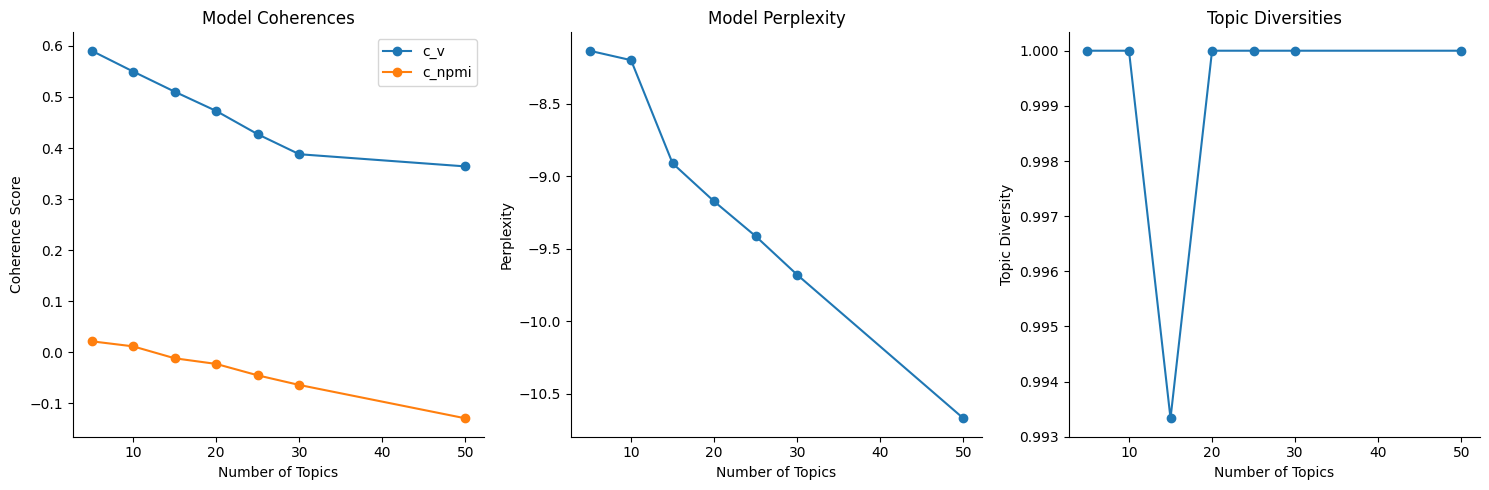

In [21]:
#Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

#Plot model coherences
axes[0].plot(topics_range, model_coherence_cv, marker='o', label='c_v')
axes[0].plot(topics_range, model_coherence_cnpmi, marker='o', label='c_npmi')
axes[0].set_xlabel('Number of Topics')
axes[0].set_ylabel('Coherence Score')
axes[0].legend()
axes[0].set_title('Model Coherences')

#Plot model perplexity
axes[1].plot(topics_range, model_perplexity, marker='o')
axes[1].set_xlabel('Number of Topics')
axes[1].set_ylabel('Perplexity')
axes[1].set_title('Model Perplexity')

#Plot topic diversities
axes[2].plot(topics_range, topic_diversity, marker='o')
axes[2].set_xlabel('Number of Topics')
axes[2].set_ylabel('Topic Diversity')
axes[2].set_title('Topic Diversities')

#Remove right and top borders for each plot
for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig('lda_metrics_plots.png')
plt.show()


<p>The evaluation metrics used all point to 5 as the optimal number of topics. 
We will now visually inspect the output of each proposed model, and using our word2vec model, 
we will check the average similarity of the top 10 words in each topic of each proposed model</p>

<span style="color: red; font-family: Calibri Light;">
  <h3><b>define function to train, evaluate and visualize the models</b></h3>
</span>

In [22]:
params = {
    'alpha': 'auto',
    'eta': 'auto',
    'chunksize': 5000,
    'passes': 10,
    'iterations': 400,
    'eval_every': None
}

In [23]:
#function to train model
def train_model(num_topics, random_state, corpus, id2word, **kwargs):
    temp = dictionary[0]
    lda_model = LdaModel(num_topics= num_topics, random_state = random_state, corpus = corpus, id2word = id2word, **kwargs)
    
    return lda_model

#function to compute coherence, diversity and perplexity metrics
def eval_metrics (lda_model, docs, dictionary, num_topics, top_n = 10):
    #Compute c_v score
    c_v = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
    cv_lda = c_v.get_coherence()
    
    # Compute u_mass score
    u_mass = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='u_mass')
    umass_lda = u_mass.get_coherence()
    
    # Compute c_npmi score
    c_npmi = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_npmi')
    cnpmi_lda = c_npmi.get_coherence()
    
    # Compute perplexity
    perplexity = lda_model.log_perplexity(corpus)
    
    # Compute topic diversity
    top_words = [word for topic_id in range(num_topics) for word, _ in lda_model.show_topic(topic_id, topn=top_n)]
    diversity = len(set(top_words)) / (num_topics * top_n)
    
    return cv_lda, umass_lda, cnpmi_lda, perplexity, diversity

#function to check average word similarities for the topics 
def average_similarity(lda_model, num_topics, w2v_model, top_n=10):
    #extract top 10 words for each topic
    top_words_per_topic =[] 
    for topic_id in range(num_topics):
        top_words = lda_model.show_topic(topic_id, topn=top_n)
        top_words = [word for word, _ in top_words]
        top_words_per_topic.append(top_words)
        
    # 2. Compute pairwise similarities for each topic
    average_similarities = []
    for top_words in top_words_per_topic:
        total_similarity = 0
        count = 0
        for i in range(len(top_words)):
            for j in range(i+1, len(top_words)):  # Compare each word with the words after it
                if top_words[i] in w2v_model.wv and top_words[j] in w2v_model.wv:
                    similarity = w2v_model.wv.similarity(top_words[i], top_words[j])
                    total_similarity += similarity
                    count += 1
        average_similarity = total_similarity / count if count != 0 else 0
        average_similarities.append(average_similarity)
        
    return average_similarities

#function to create bar charts of the top_n words of the topics
def plot_topic_barchat(lda_model, top_n=10):
    num_topics = lda_model.num_topics
    cols = int(np.ceil(num_topics ** 0.5))  # Square root to decide number of columns
    rows = int(np.ceil(num_topics / cols))  # Calculate rows based on columns
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    
    # If only one topic, axes is not an array
    if num_topics == 1:
        axes = [axes]
    else:
        axes = axes.ravel()

    for topic_num in range(num_topics):
        top_words = lda_model.show_topic(topic_num, topn=top_n)
        topic_words, probs = zip(*top_words)
        
        sns.barplot(x=probs, y=topic_words, ax=axes[topic_num], palette='viridis')
        axes[topic_num].set_title(f'Topic {topic_num}')
        axes[topic_num].set_xlabel('Probability')
    
    # Remove any remaining empty subplots
    for i in range(num_topics, rows*cols):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.suptitle('Top Words for Each Topic', y=1.02, fontsize=16)
    plt.show()

In [24]:
def train_model_vis_check_similarity (num_topics, random_state, corpus,dictionary,w2v_model, top_n, docs, **kwargs):
    lda_model = train_model(num_topics=num_topics, random_state=random_state, corpus=corpus, id2word=dictionary.id2token, **kwargs)
    cv_lda, umass_lda, cnpmi_lda, perplexity, diversity = eval_metrics (lda_model, docs, dictionary, num_topics, top_n)
    average_similarities  = average_similarity(lda_model, num_topics, w2v_model, top_n)
    
    print(f"For {num_topics} topics:\nCoherence(c_v) = {cv_lda},\nCoherence(c_npmi) = {cnpmi_lda},\nCoherence(u_mass) = {umass_lda},\nPerplexity = {perplexity},\nTopic Diversity = {diversity}\n")
    
    return lda_model, average_similarities

<span style="color: red; font-family: Calibri Light;">
  <h3><b>a. model 1: 5 topics</b></h3>
</span>

In [30]:
model_1, avg_sims1 = train_model_vis_check_similarity(num_topics = 5, random_state = 5, 
                                                      w2v_model = w2v_model,
                                                      corpus = corpus,docs = docs, 
                                                      dictionary = dictionary, top_n = 10, **params)

#print average similarities for each topic
for idx, avg_sim in enumerate(avg_sims1):
    print(f"Average similarity for topic {idx}: {avg_sim:.4f}")

For 5 topics:
Coherence(c_v) = 0.6049680135364921,
Coherence(c_npmi) = 0.01809764921147028,
Coherence(u_mass) = -3.6348576844708056,
Perplexity = -8.133242506530346,
Topic Diversity = 1.0

Average similarity for topic 0: 0.4982
Average similarity for topic 1: 0.4522
Average similarity for topic 2: 0.2859
Average similarity for topic 3: 0.4426
Average similarity for topic 4: 0.5138


In [31]:
#save model
model_1.save('../models/model_1_5tpcs/lda_model_1_5tpcs')

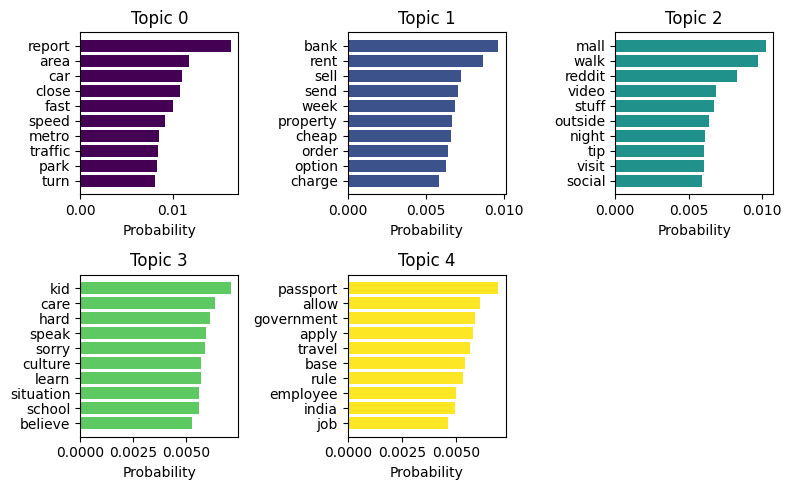

In [32]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#number of topics
num_topics = model_1.num_topics

# Number of words to display for each topic
num_words = 10

#define color map
colors = cm.viridis(np.linspace(0,1, num_topics))

#subplot layout
rows = 2
cols = int(np.ceil(num_topics/rows))

plt.figure(figsize=(8,5))


# Iterate through the topics
for topic_num in range(num_topics):
    # top words and their probabilities for each topic
    top_words = model_1.show_topic(topic_num, topn=num_words)
    
    # Separate the words and probabilities
    topic_words, probs = zip(*top_words)
    
    #create subplot
    plt.subplot(rows, cols, topic_num +1)
    
    # Plot the words and probabilities as a horizontal bar chart
    plt.barh(topic_words, probs, color = colors[topic_num])
    plt.xlabel('Probability')
    plt.title(f'Topic {topic_num}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest probability at the top

plt.tight_layout()
plt.show()

In [33]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model_1, corpus, dictionary, sort_topics = False)
pyLDAvis.display(vis)

<span style="color: red; font-family: Calibri Light;">
  <h3><b>b. model 2: 10 topics</b></h3>
</span>

In [34]:
model_2, avg_sims2 = train_model_vis_check_similarity(num_topics = 10, random_state = 1101, 
                                                      w2v_model = w2v_model,
                                                      corpus = corpus,docs = docs, 
                                                      dictionary = dictionary, top_n = 10, **params)

#print average similarities for each topic
for idx, avg_sim in enumerate(avg_sims2):
    print(f"Average similarity for topic {idx}: {avg_sim:.4f}")

For 10 topics:
Coherence(c_v) = 0.4895138013398749,
Coherence(c_npmi) = -0.02281372631638639,
Coherence(u_mass) = -4.798116025994018,
Perplexity = -8.206242644049633,
Topic Diversity = 1.0

Average similarity for topic 0: 0.7092
Average similarity for topic 1: 0.5578
Average similarity for topic 2: 0.4880
Average similarity for topic 3: 0.5324
Average similarity for topic 4: 0.5290
Average similarity for topic 5: 0.6461
Average similarity for topic 6: 0.5922
Average similarity for topic 7: 0.3237
Average similarity for topic 8: 0.4213
Average similarity for topic 9: 0.4569


In [36]:
#save model
model_2.save('../models/model_2_10tpcs/lda_model_2_10tpcs')

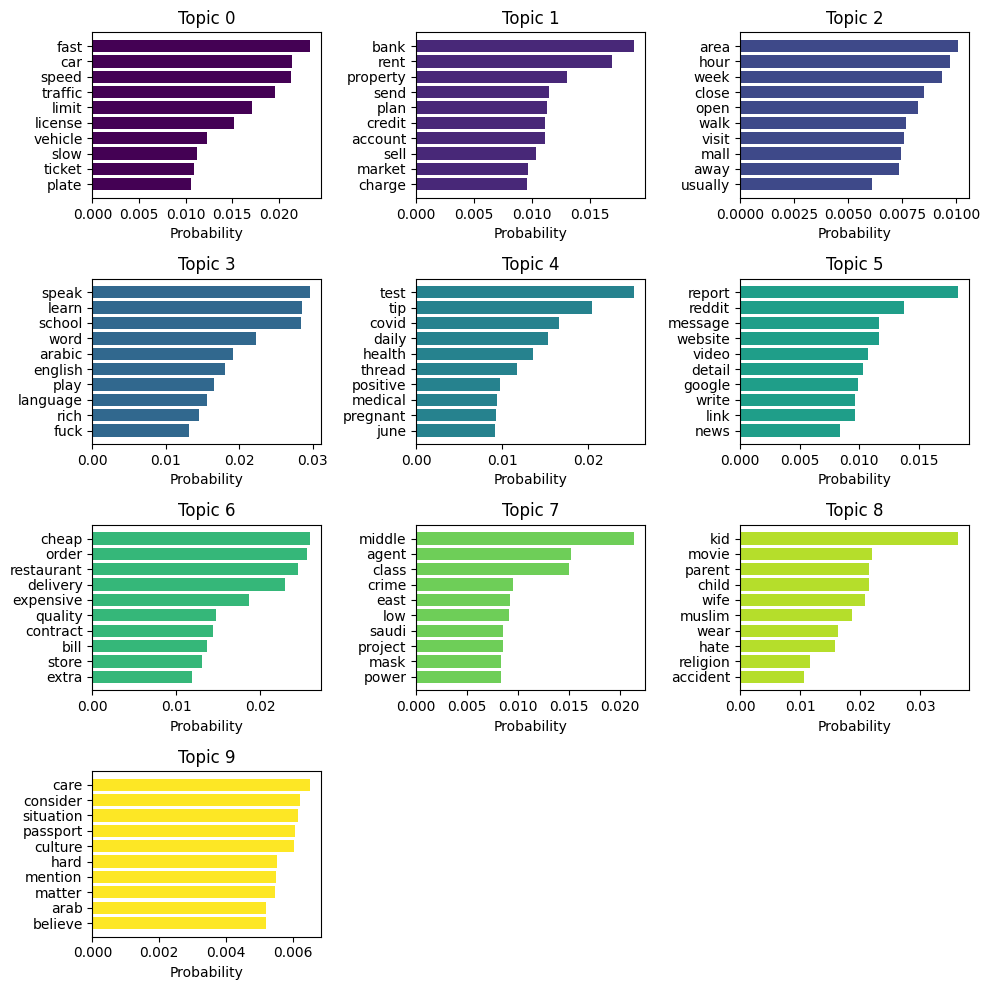

In [35]:

#visualize the topics in a barchart
#number of topics
num_topics = model_2.num_topics

# Number of words to display for each topic
num_words = 10

#define color map
colors = cm.viridis(np.linspace(0,1, num_topics))

#subplot layout
rows = 4
cols = int(np.ceil(num_topics/rows))

plt.figure(figsize=(10,10))


# Iterate through the topics
for topic_num in range(num_topics):
    # top words and their probabilities for each topic
    top_words = model_2.show_topic(topic_num, topn=num_words)
    
    # Separate the words and probabilities
    topic_words, probs = zip(*top_words)
    
    #create subplot
    plt.subplot(rows, cols, topic_num +1)
    
    # Plot the words and probabilities as a horizontal bar chart
    plt.barh(topic_words, probs, color = colors[topic_num])
    plt.xlabel('Probability')
    plt.title(f'Topic {topic_num}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest probability at the top

plt.tight_layout()
plt.show()

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model_2, corpus, dictionary, sort_topics = False)
pyLDAvis.display(vis)

<span style="color: red; font-family: Calibri Light;">
  <h3><b>c. model 3: 15 topics</b></h3>
</span>

In [37]:
model_3, avg_sims3 = train_model_vis_check_similarity(num_topics = 15, random_state = 1151, 
                                                      w2v_model = w2v_model,
                                                      corpus = corpus,docs = docs, 
                                                      dictionary = dictionary, top_n = 10, **params)

#print average similarities for each topic
for idx, avg_sim in enumerate(avg_sims3):
    print(f"Average similarity for topic {idx}: {avg_sim:.4f}")

For 15 topics:
Coherence(c_v) = 0.46347251677274065,
Coherence(c_npmi) = -0.026488737095068004,
Coherence(u_mass) = -5.084119863191523,
Perplexity = -8.920892517340928,
Topic Diversity = 0.9933333333333333

Average similarity for topic 0: 0.3907
Average similarity for topic 1: 0.5440
Average similarity for topic 2: 0.7234
Average similarity for topic 3: 0.1976
Average similarity for topic 4: 0.3399
Average similarity for topic 5: 0.6650
Average similarity for topic 6: 0.4382
Average similarity for topic 7: 0.6379
Average similarity for topic 8: 0.5084
Average similarity for topic 9: 0.4833
Average similarity for topic 10: 0.4693
Average similarity for topic 11: 0.2890
Average similarity for topic 12: 0.4452
Average similarity for topic 13: 0.4227
Average similarity for topic 14: 0.5073


In [39]:
#save model
model_3.save('../models/model_3_15tpcs/lda_model_3_15tpcs')

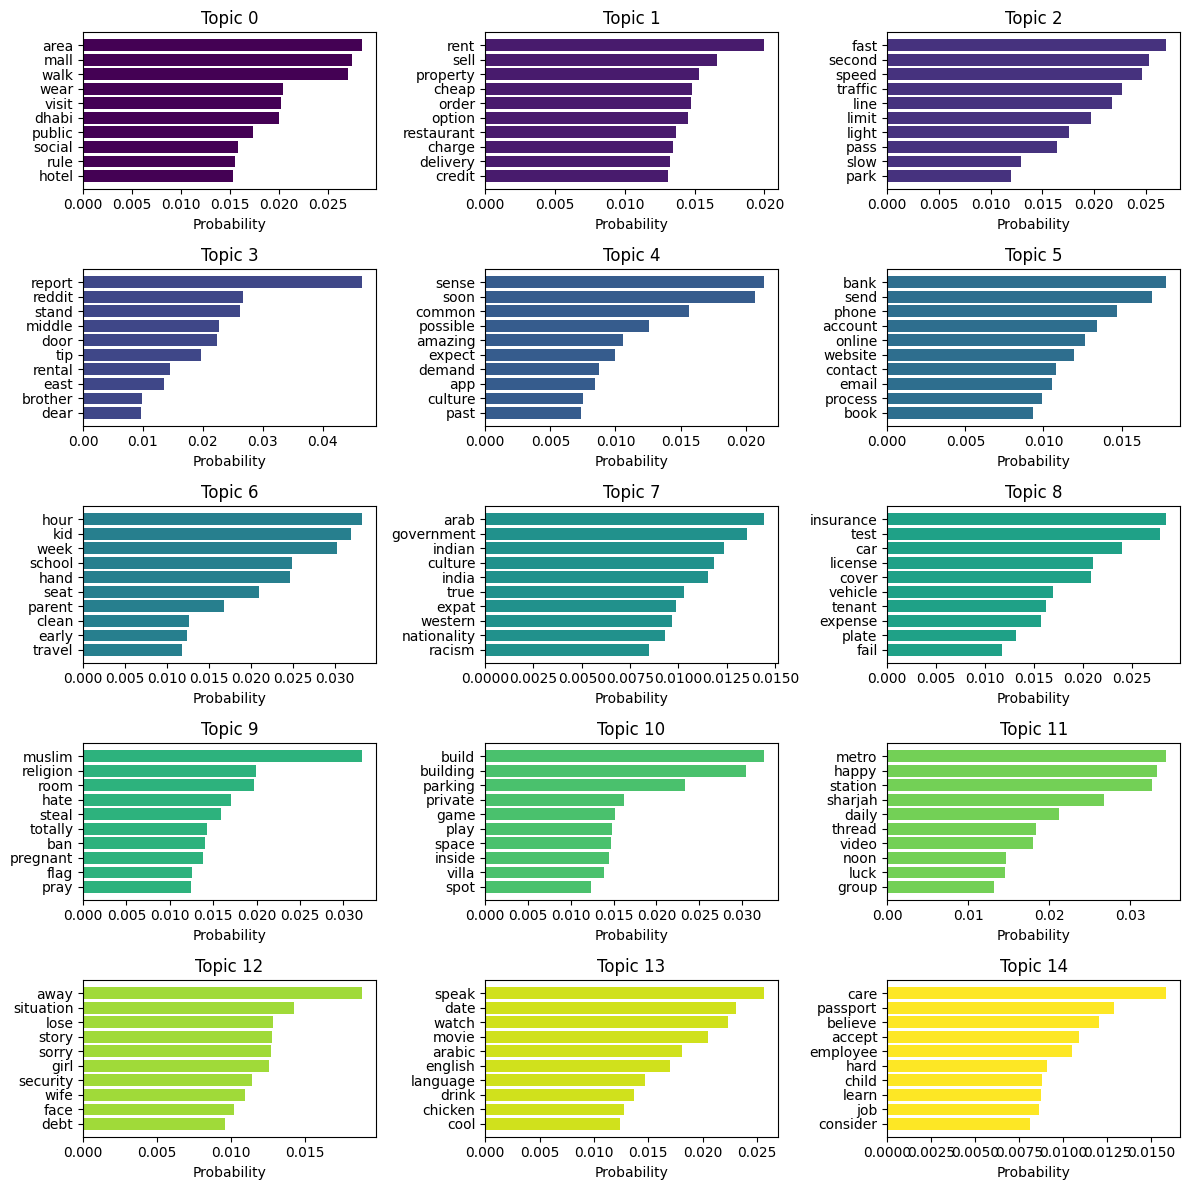

In [38]:

#visualize the topics in a barchart
#number of topics
num_topics = model_3.num_topics

# Number of words to display for each topic
num_words = 10

#define color map
colors = cm.viridis(np.linspace(0,1, num_topics))

#subplot layout
rows = 5
cols = int(np.ceil(num_topics/rows))

plt.figure(figsize=(12,12))


# Iterate through the topics
for topic_num in range(num_topics):
    # top words and their probabilities for each topic
    top_words = model_3.show_topic(topic_num, topn=num_words)
    
    # Separate the words and probabilities
    topic_words, probs = zip(*top_words)
    
    #create subplot
    plt.subplot(rows, cols, topic_num +1)
    
    # Plot the words and probabilities as a horizontal bar chart
    plt.barh(topic_words, probs, color = colors[topic_num])
    plt.xlabel('Probability')
    plt.title(f'Topic {topic_num}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest probability at the top

plt.tight_layout()
plt.show()

In [40]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model_3, corpus, dictionary, sort_topics = False)
pyLDAvis.display(vis)

<span style="color: red; font-family: Calibri Light;">
  <h3><b>d. model 4: 20 topics</b></h3>
</span>

In [41]:
model_4, avg_sims4 = train_model_vis_check_similarity(num_topics = 20, random_state = 112, 
                                                      w2v_model = w2v_model,
                                                      corpus = corpus,docs = docs, 
                                                      dictionary = dictionary, top_n = 10, **params)

#print average similarities for each topic
for idx, avg_sim in enumerate(avg_sims4):
    print(f"Average similarity for topic {idx}: {avg_sim:.4f}")

For 20 topics:
Coherence(c_v) = 0.45719477033031203,
Coherence(c_npmi) = -0.0282779422731149,
Coherence(u_mass) = -4.898497802637102,
Perplexity = -9.17930373487496,
Topic Diversity = 1.0

Average similarity for topic 0: 0.5438
Average similarity for topic 1: 0.5287
Average similarity for topic 2: 0.3807
Average similarity for topic 3: 0.5684
Average similarity for topic 4: 0.2829
Average similarity for topic 5: 0.4078
Average similarity for topic 6: 0.6791
Average similarity for topic 7: 0.5954
Average similarity for topic 8: 0.4531
Average similarity for topic 9: 0.2947
Average similarity for topic 10: 0.4836
Average similarity for topic 11: 0.4723
Average similarity for topic 12: 0.5367
Average similarity for topic 13: 0.3404
Average similarity for topic 14: 0.4035
Average similarity for topic 15: 0.5397
Average similarity for topic 16: 0.3451
Average similarity for topic 17: 0.5108
Average similarity for topic 18: 0.5223
Average similarity for topic 19: 0.6429


In [43]:
#save model
model_4.save('../models/model_4_20tpcs/lda_model_4_20tpcs')

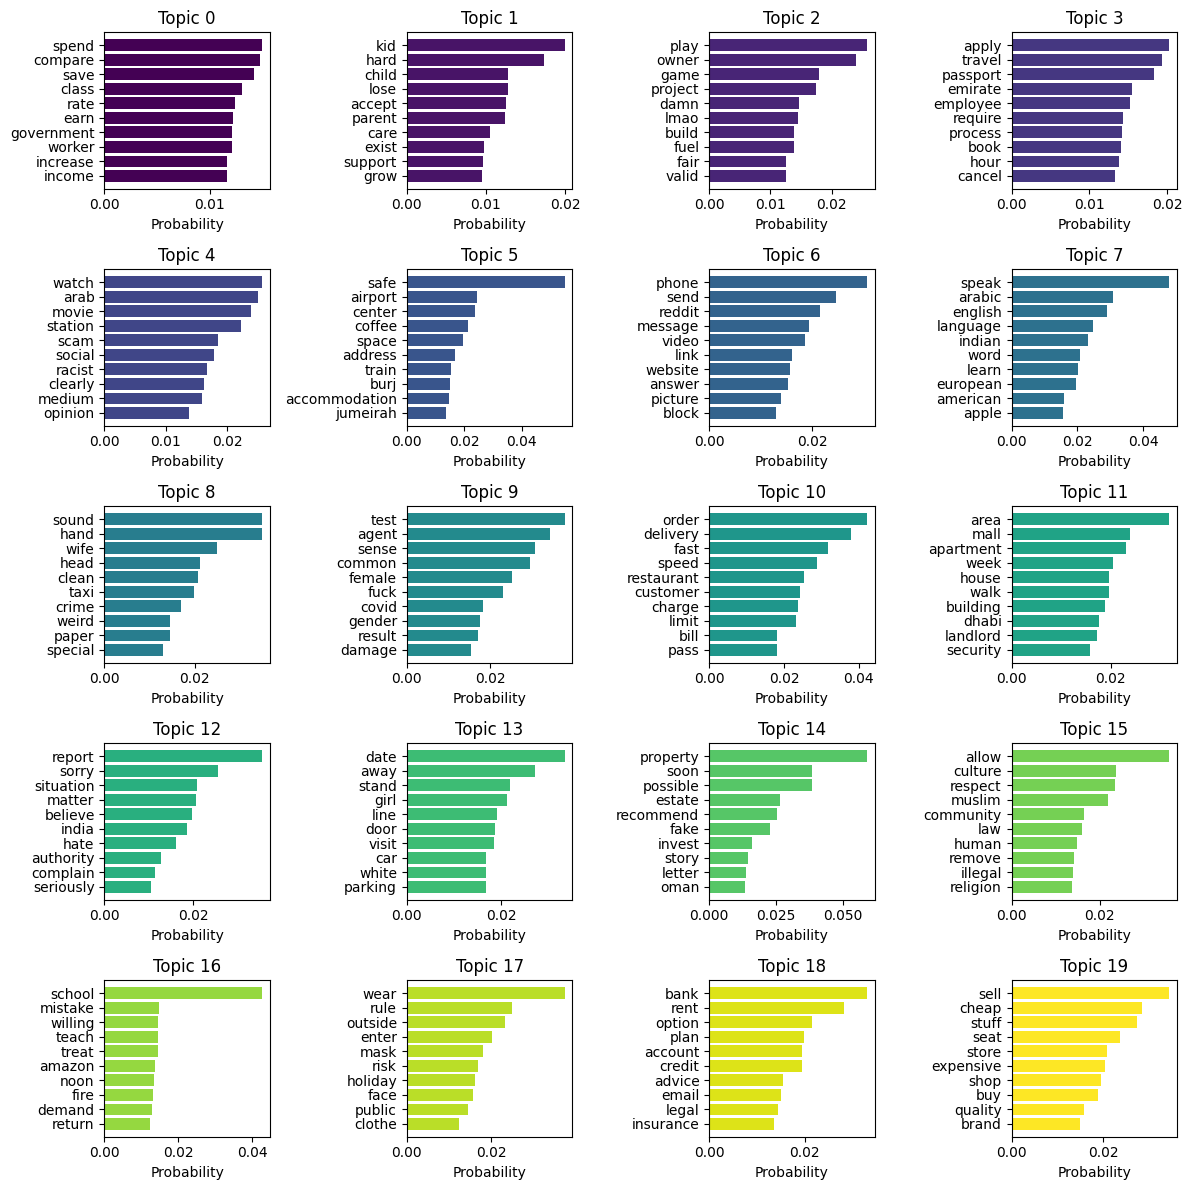

In [42]:

#visualize the topics in a barchart
#number of topics
num_topics = model_4.num_topics

# Number of words to display for each topic
num_words = 10

#define color map
colors = cm.viridis(np.linspace(0,1, num_topics))

#subplot layout
rows = 5
cols = int(np.ceil(num_topics/rows))

plt.figure(figsize=(12,12))


# Iterate through the topics
for topic_num in range(num_topics):
    # top words and their probabilities for each topic
    top_words = model_4.show_topic(topic_num, topn=num_words)
    
    # Separate the words and probabilities
    topic_words, probs = zip(*top_words)
    
    #create subplot
    plt.subplot(rows, cols, topic_num +1)
    
    # Plot the words and probabilities as a horizontal bar chart
    plt.barh(topic_words, probs, color = colors[topic_num])
    plt.xlabel('Probability')
    plt.title(f'Topic {topic_num}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest probability at the top

plt.tight_layout()
plt.show()

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model_4, corpus, dictionary, sort_topics = False)
pyLDAvis.display(vis)

<span style="color: red; font-family: Calibri Light;">
  <h3><b>e. model 5: 25 topics</b></h3>
</span>

In [44]:
model_5, avg_sims5 = train_model_vis_check_similarity(num_topics = 25, random_state = 125, 
                                                      w2v_model = w2v_model,
                                                      corpus = corpus,docs = docs, 
                                                      dictionary = dictionary, top_n = 10, **params)

#print average similarities for each topic
for idx, avg_sim in enumerate(avg_sims5):
    print(f"Average similarity for topic {idx}: {avg_sim:.4f}")

For 25 topics:
Coherence(c_v) = 0.4370927325782465,
Coherence(c_npmi) = -0.04470407911136721,
Coherence(u_mass) = -5.184369933326291,
Perplexity = -9.434403022144888,
Topic Diversity = 1.0

Average similarity for topic 0: 0.4606
Average similarity for topic 1: 0.4066
Average similarity for topic 2: 0.4484
Average similarity for topic 3: 0.5007
Average similarity for topic 4: 0.3327
Average similarity for topic 5: 0.3551
Average similarity for topic 6: 0.5517
Average similarity for topic 7: 0.3855
Average similarity for topic 8: 0.5423
Average similarity for topic 9: 0.5204
Average similarity for topic 10: 0.5186
Average similarity for topic 11: 0.4796
Average similarity for topic 12: 0.3581
Average similarity for topic 13: 0.3215
Average similarity for topic 14: 0.6221
Average similarity for topic 15: 0.6366
Average similarity for topic 16: 0.5926
Average similarity for topic 17: 0.5678
Average similarity for topic 18: 0.4921
Average similarity for topic 19: 0.3593
Average similarity f

In [46]:
#save model
model_5.save('../models/model_5_25tpcs/lda_model_5_25tpcs')

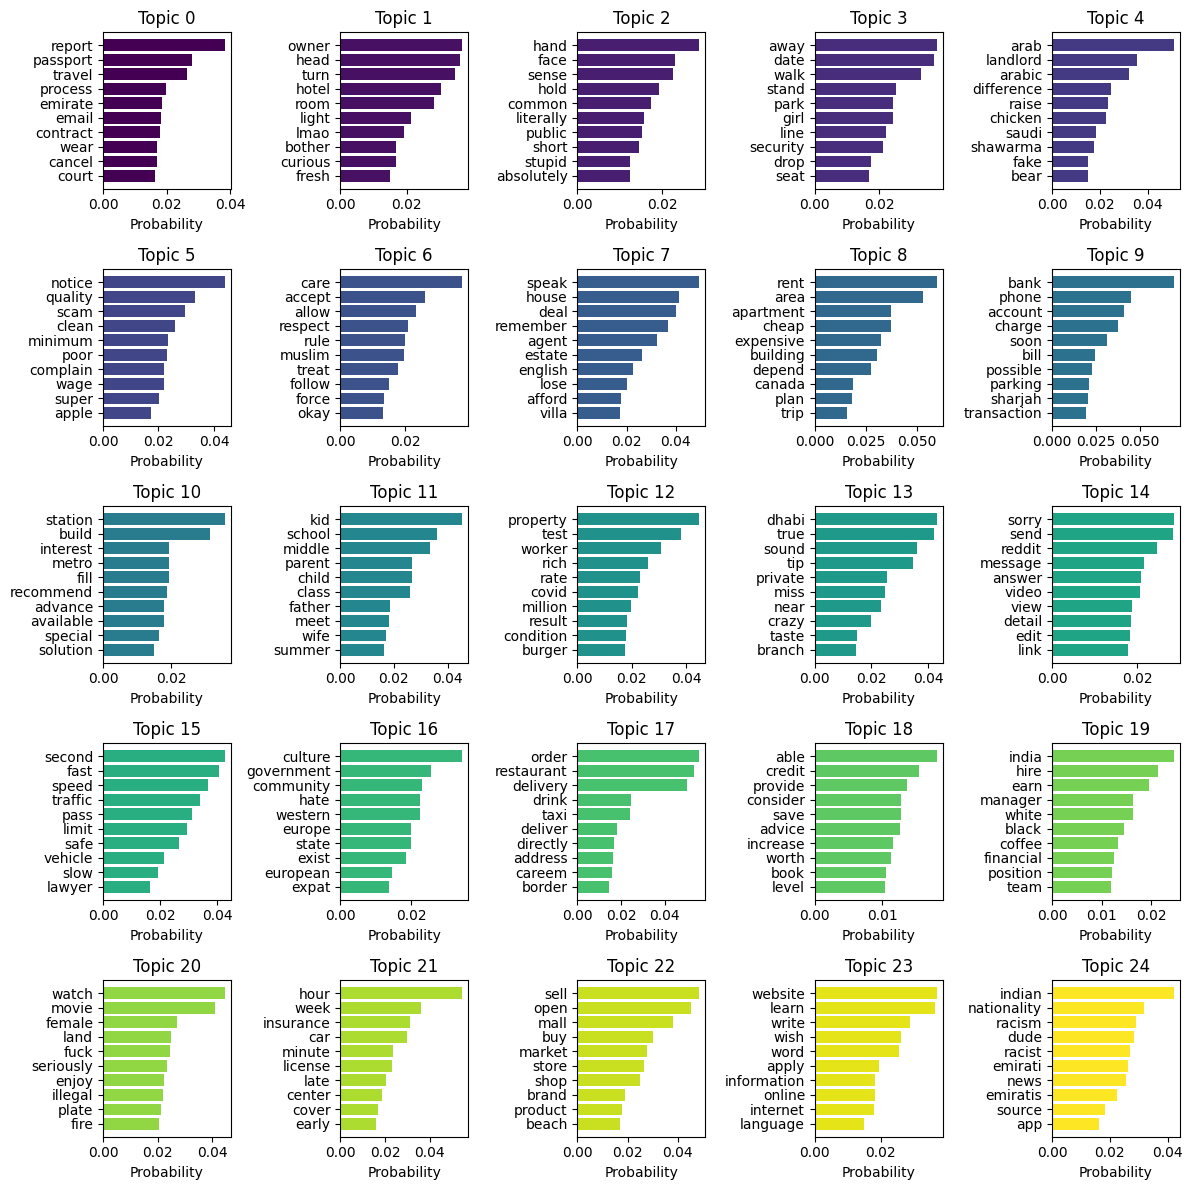

In [45]:

#visualize the topics in a barchart
#number of topics
num_topics = model_5.num_topics

# Number of words to display for each topic
num_words = 10

#define color map
colors = cm.viridis(np.linspace(0,1, num_topics))

#subplot layout
rows = 5
cols = int(np.ceil(num_topics/rows))

plt.figure(figsize=(12,12))


# Iterate through the topics
for topic_num in range(num_topics):
    # top words and their probabilities for each topic
    top_words = model_5.show_topic(topic_num, topn=num_words)
    
    # Separate the words and probabilities
    topic_words, probs = zip(*top_words)
    
    #create subplot
    plt.subplot(rows, cols, topic_num +1)
    
    # Plot the words and probabilities as a horizontal bar chart
    plt.barh(topic_words, probs, color = colors[topic_num])
    plt.xlabel('Probability')
    plt.title(f'Topic {topic_num}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest probability at the top

plt.tight_layout()
plt.show()

In [47]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model_5, corpus, dictionary, sort_topics = False)
pyLDAvis.display(vis)

<span style="color: red; font-family: Calibri Light;">
  <h3><b>f. model 6: 50 topics</b></h3>
</span>

In [48]:
model_6, avg_sims6 = train_model_vis_check_similarity(num_topics = 50, random_state = 1150, 
                                                      w2v_model = w2v_model,
                                                      corpus = corpus,docs = docs, 
                                                      dictionary = dictionary, top_n = 10, **params)

#print average similarities for each topic
for idx, avg_sim in enumerate(avg_sims6):
    print(f"Average similarity for topic {idx}: {avg_sim:.4f}")

For 50 topics:
Coherence(c_v) = 0.349755484345094,
Coherence(c_npmi) = -0.12241838164155293,
Coherence(u_mass) = -6.804416525871346,
Perplexity = -10.65772625265206,
Topic Diversity = 0.998

Average similarity for topic 0: 0.4441
Average similarity for topic 1: 0.5284
Average similarity for topic 2: 0.4788
Average similarity for topic 3: 0.4666
Average similarity for topic 4: 0.4906
Average similarity for topic 5: 0.2714
Average similarity for topic 6: 0.2692
Average similarity for topic 7: 0.3979
Average similarity for topic 8: 0.4336
Average similarity for topic 9: 0.4265
Average similarity for topic 10: 0.3193
Average similarity for topic 11: 0.5238
Average similarity for topic 12: 0.3301
Average similarity for topic 13: 0.7206
Average similarity for topic 14: 0.4905
Average similarity for topic 15: 0.5799
Average similarity for topic 16: 0.4954
Average similarity for topic 17: 0.7590
Average similarity for topic 18: 0.3308
Average similarity for topic 19: 0.5222
Average similarity 

In [ ]:
#save model
model_6.save('../models/model_6_50tpcs/lda_model_6_50tpcs')

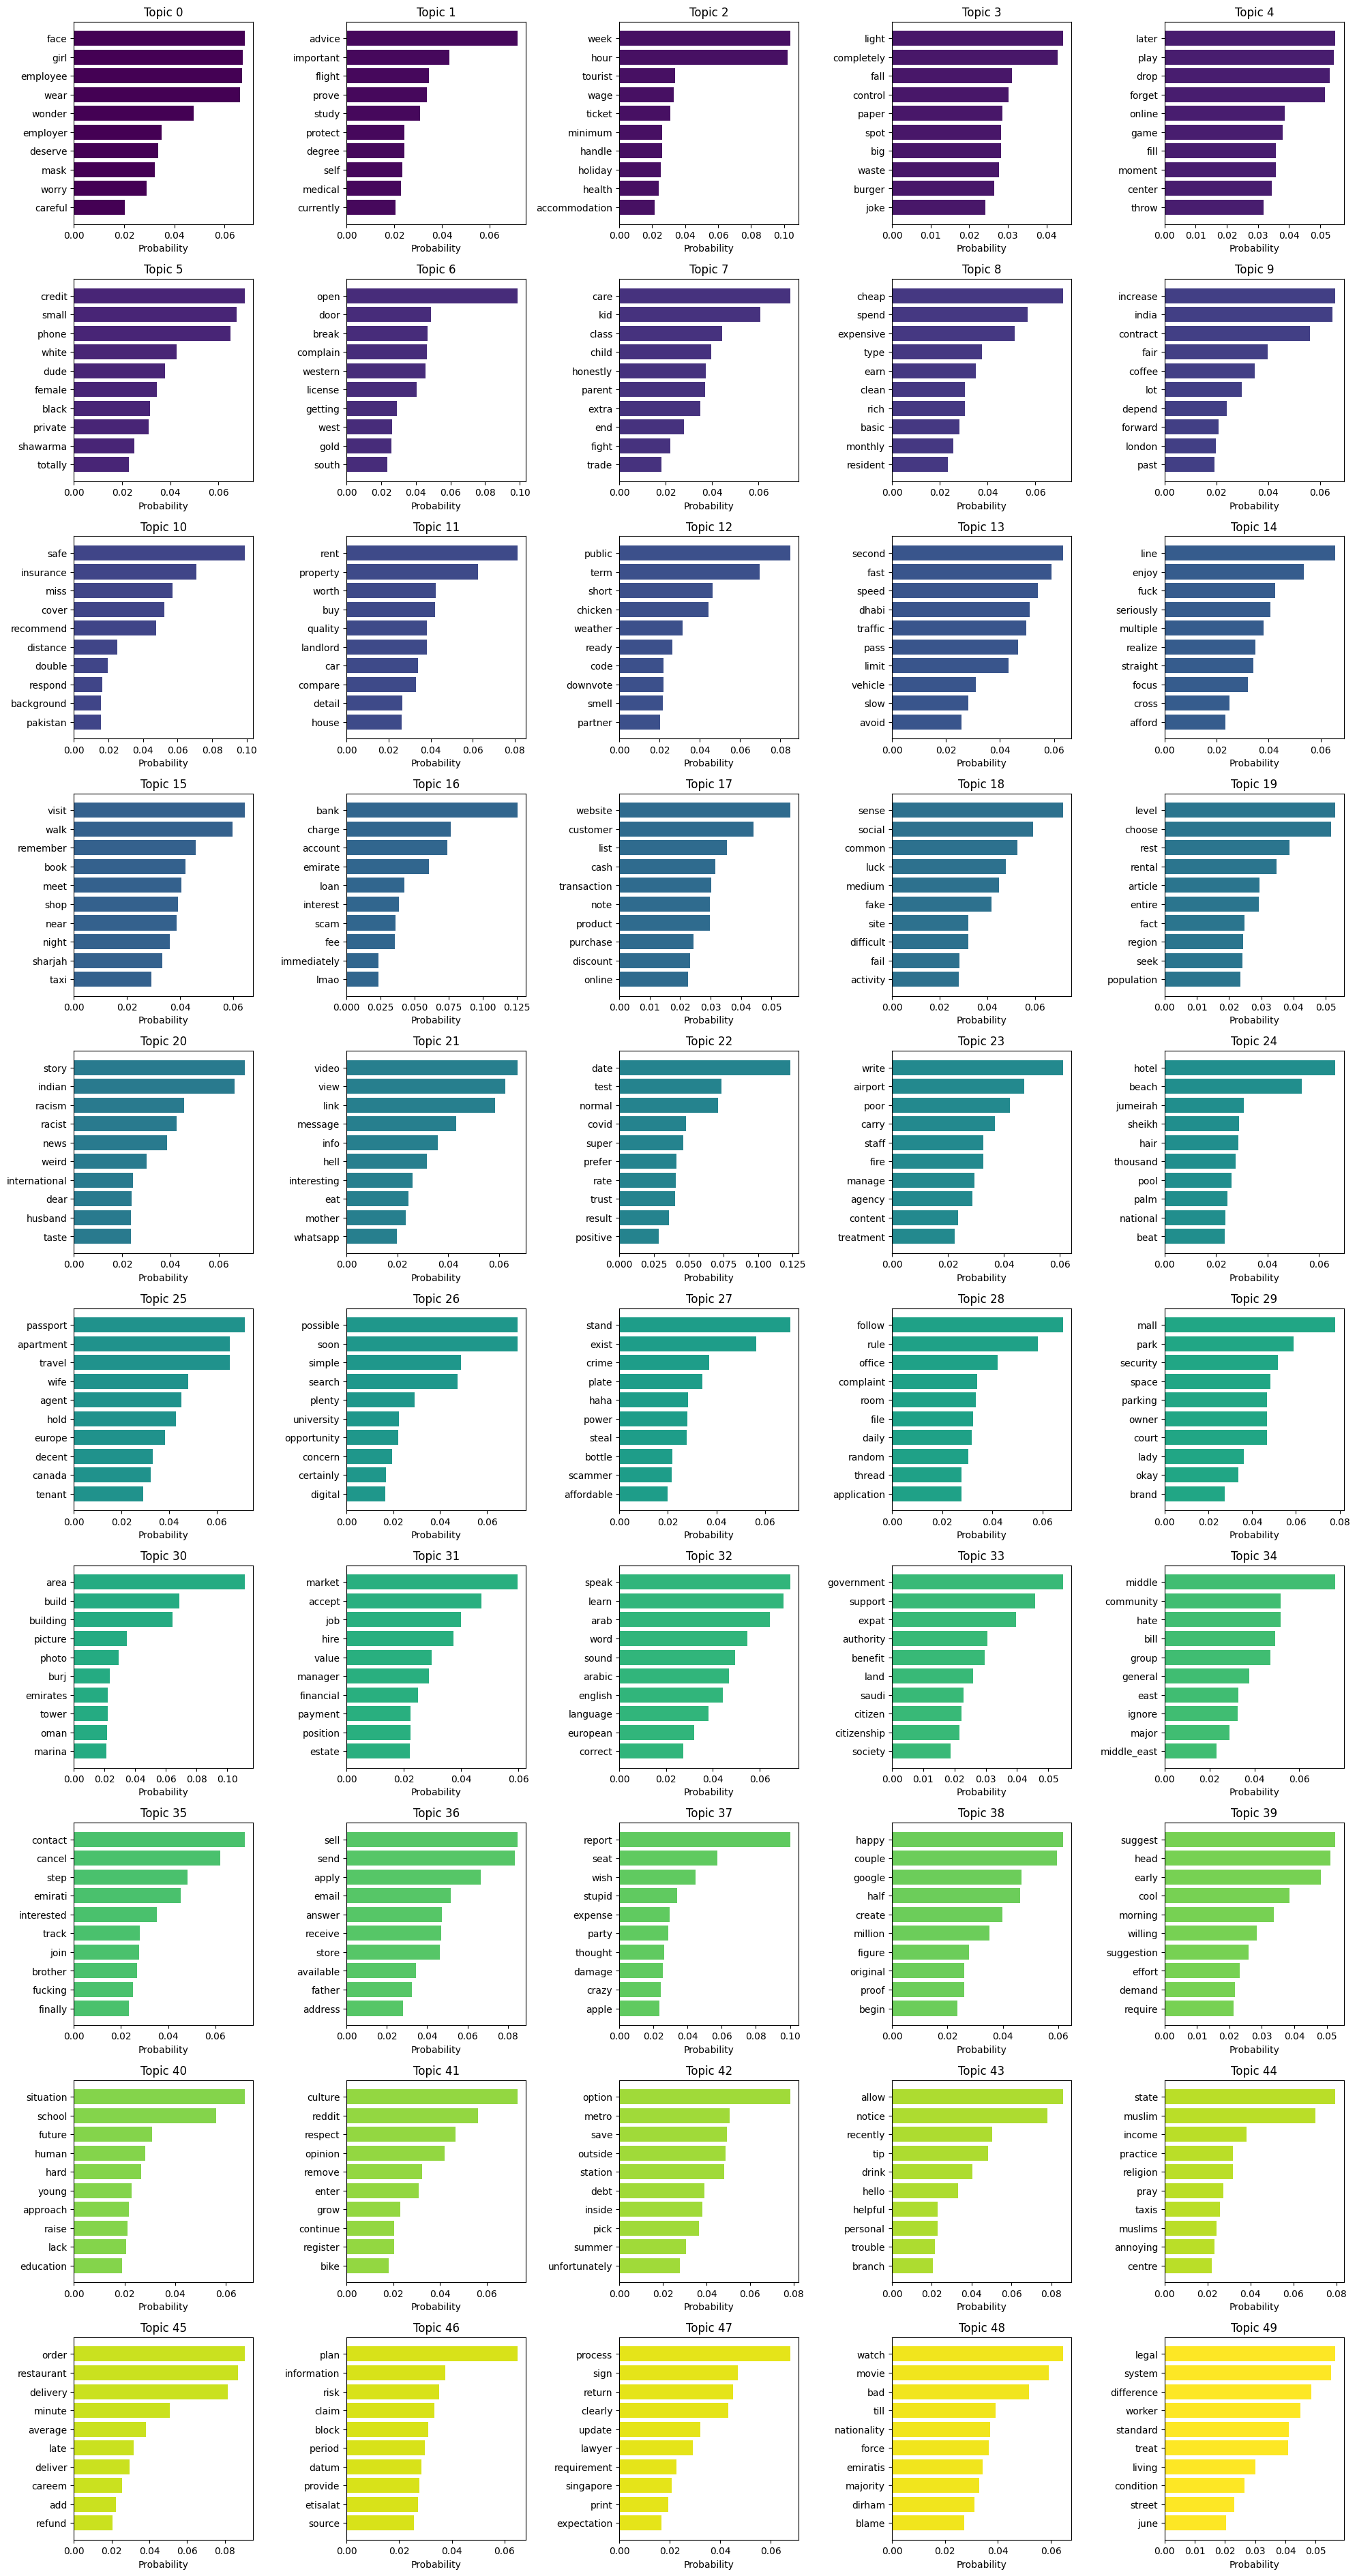

In [49]:

#visualize the topics in a barchart
#number of topics
num_topics = model_6.num_topics

# Number of words to display for each topic
num_words = 10

#define color map
colors = cm.viridis(np.linspace(0,1, num_topics))

#subplot layout
rows = 12
cols = int(np.ceil(num_topics/rows))

plt.figure(figsize=(20,45))


# Iterate through the topics
for topic_num in range(num_topics):
    # top words and their probabilities for each topic
    top_words = model_6.show_topic(topic_num, topn=num_words)
    
    # Separate the words and probabilities
    topic_words, probs = zip(*top_words)
    
    #create subplot
    plt.subplot(rows, cols, topic_num +1)
    
    # Plot the words and probabilities as a horizontal bar chart
    plt.barh(topic_words, probs, color = colors[topic_num])
    plt.xlabel('Probability')
    plt.title(f'Topic {topic_num}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest probability at the top

plt.tight_layout()
plt.show()

In [50]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model_6, corpus, dictionary, sort_topics = False)
pyLDAvis.display(vis)

---